# Packages

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN,LSTM,Dropout,BatchNormalization,Reshape
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras import layers

# Data preparation

Import data and have a look on the head.

In [2]:
path = './Data/train/'
data = pd.read_csv(path+'AAPL.csv',parse_dates=True, index_col = "Dt")
data.head()

,Adj Close,Close,Div,Factor,High,Low,Open,Volume
Dt,,,,,,,,
2000-01-03,3.4785,111.938,0.0,1.0,112.500,101.688,104.8750,133949200.0
2000-01-04,3.1852,102.500,0.0,1.0,110.625,101.188,108.2500,128094400.0
2000-01-05,3.2318,104.000,0.0,1.0,110.563,103.000,103.7500,194580400.0
2000-01-06,2.9521,95.000,0.0,1.0,107.000,95.000,106.1183,191993200.0
2000-01-07,3.0920,99.500,0.0,1.0,101.000,95.500,96.5000,115183600.0


We observe that the Div and Fator features are mostly 0 and 1, which have nearly no variance, so we remove the two features.

In [3]:
data = data.iloc[:,[0,1,4,5,6,7]]
data.head()

,Adj Close,Close,High,Low,Open,Volume
Dt,,,,,,
2000-01-03,3.4785,111.938,112.500,101.688,104.8750,133949200.0
2000-01-04,3.1852,102.500,110.625,101.188,108.2500,128094400.0
2000-01-05,3.2318,104.000,110.563,103.000,103.7500,194580400.0
2000-01-06,2.9521,95.000,107.000,95.000,106.1183,191993200.0
2000-01-07,3.0920,99.500,101.000,95.500,96.5000,115183600.0


In [4]:
data.dtypes

Adj Close    float64
Close        float64
High         float64
Low          float64
Open         float64
Volume       float64
dtype: object

In [5]:
data.isnull().sum()

Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64

The data types are all float and there is no null value.

# Feature engineering

Many investors follow technical indicators. Then, We create some technical indicators as our features from the raw price-volume data.

In [6]:
def addPositive(x):
    return x[x>0].sum()

def addNegative(x):
    return -x[x<0].sum()

In [7]:
def get_technical_indicators(dataset):
   # Create 7 and 21 days Moving Average
   dataset['ma7'] = dataset['Close'].rolling(window=7).mean()
   dataset['ma21'] = dataset['Close'].rolling(window=21).mean()
   
   # Create MACD
   dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
   dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
   dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

   # Create Bollinger Bands
   dataset['20sd'] = dataset['Close'].rolling(window=20).std()
   dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*1.96)
   dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*1.96)
   
   # Create Exponential moving average
   dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
   
   # Create Momentum
   dataset['momentum'] = dataset['Close']-dataset['Close'].shift(10)
    
   # Create Average True Range
   dataset['HLrange'] = (dataset['High']-dataset['Low']).abs()
   dataset['HCrange'] = (dataset['High']-dataset['Close'].shift(1)).abs()
   dataset['CLrange'] = (dataset['Close'].shift(1)-dataset['Low']).abs()
   dataset['TR'] = dataset.loc[:,['HLrange','HCrange','CLrange']].max(axis=1)
   dataset['ATR'] = dataset['TR'].rolling(window=20).mean()
    
   # Create Volume Ratio
   dataset['Vlchange'] = dataset['Volume'] - dataset['Volume'].shift(1)
   dataset['VR'] = dataset['Vlchange'].rolling(window=14).apply(addPositive)/dataset['Vlchange'].rolling(window=14).apply(addNegative)
   
   # Create William Ratio
   dataset['WR'] =  (dataset['High'].rolling(window=14).max()-dataset['Close']) \
    /(dataset['High'].rolling(window=14).max()-dataset['Low'].rolling(window=14).min())*100
    
   # Create Money Flow Index
   dataset['MoneyFlow'] = dataset.loc[:,['High','Low','Close']].mean(axis=1)*dataset['Volume']
   dataset['Mfchange'] = dataset['MoneyFlow'] - dataset['MoneyFlow'].shift(1)
   dataset['MFI'] = dataset['Vlchange'].rolling(window=14).apply(addPositive)/dataset['Vlchange'].rolling(window=14).apply(addNegative)
   
   # Create Open-Close Range
   dataset['OCR'] = dataset['Open']-dataset['Close'].shift(1)

   return dataset

In [8]:
data_new = get_technical_indicators(data)

Change Close price to percentage return.

In [9]:
data_new['Return'] = data_new['Close'].pct_change()
data_new.tail()

,Adj Close,Close,High,Low,Open,Volume,ma7,ma21,26ema,12ema,...,TR,ATR,Vlchange,VR,WR,MoneyFlow,Mfchange,MFI,OCR,Return
Dt,,,,,,,,,,,,,,,,,,,,,
2016-12-23,111.3073,116.52,116.5255,115.59,115.5900,14249500.0,116.464286,113.324762,113.801231,115.286228,...,0.9355,1.589260,-11836400.0,0.694563,11.750600,1.655961e+09,-1.373830e+09,0.694563,-0.7000,0.001978
2016-12-27,112.0142,117.26,117.8000,116.49,116.5200,18296900.0,116.670000,113.585238,114.057436,115.589885,...,1.3100,1.601365,4047400.0,0.862863,6.250000,2.144092e+09,4.881312e+08,0.862863,0.0000,0.006351
2016-12-28,111.5366,116.76,118.0170,116.20,117.5200,20905900.0,116.782857,113.832381,114.257626,115.769903,...,1.8170,1.594215,2609000.0,0.842129,16.947553,2.445830e+09,3.017383e+08,0.842129,0.2600,-0.004264
2016-12-29,111.5079,116.73,117.1094,116.40,116.4500,15039500.0,116.795714,114.083333,114.440765,115.917610,...,0.7094,1.533185,-5866400.0,0.801284,22.551253,1.755808e+09,-6.900215e+08,0.801284,-0.3100,-0.000257
2016-12-30,110.6386,115.82,117.2000,115.43,116.6577,30586300.0,116.634286,114.335714,114.542930,115.902593,...,1.7700,1.526185,15546800.0,0.936955,39.750317,3.552599e+09,1.796790e+09,0.936955,-0.0723,-0.007796


Drop the null values.

In [10]:
data_new = data_new.dropna()
data_new.head()

,Adj Close,Close,High,Low,Open,Volume,ma7,ma21,26ema,12ema,...,TR,ATR,Vlchange,VR,WR,MoneyFlow,Mfchange,MFI,OCR,Return
Dt,,,,,,,,,,,,,,,,,,,,,
2000-02-01,3.1153,100.250,105.000,100.000,104.0000,79508800.0,106.330429,103.211476,104.203369,104.824972,...,5.000,8.13104,-95911200.0,0.952000,60.714286,8.090020e+09,-9.576113e+09,0.952000,0.2500,-0.033735
2000-02-02,3.0706,98.813,102.125,97.000,100.7500,116048800.0,105.268000,102.586476,103.714083,103.876002,...,5.125,7.84979,36540000.0,0.801076,78.231034,1.152512e+10,3.435095e+09,0.801076,0.5000,-0.014334
2000-02-03,3.2104,103.313,104.250,100.250,100.3130,118798400.0,103.991286,102.625190,103.678274,103.787488,...,5.437,7.71849,2749600.0,0.783348,67.354021,1.218923e+10,6.641148e+08,0.783348,1.5000,0.045541
2000-02-04,3.3561,108.000,110.000,103.625,103.9380,106330000.0,103.678714,102.815667,104.058338,104.447545,...,6.687,7.45284,-12468400.0,1.017642,49.996111,1.139946e+10,-7.897685e+08,1.017642,0.6250,0.045367
2000-02-07,3.5445,114.063,114.250,105.938,108.0038,110266800.0,104.259143,103.723429,104.926138,105.949913,...,8.312,7.56844,3936800.0,0.990857,27.542302,1.228560e+10,8.861340e+08,0.990857,0.0038,0.056139


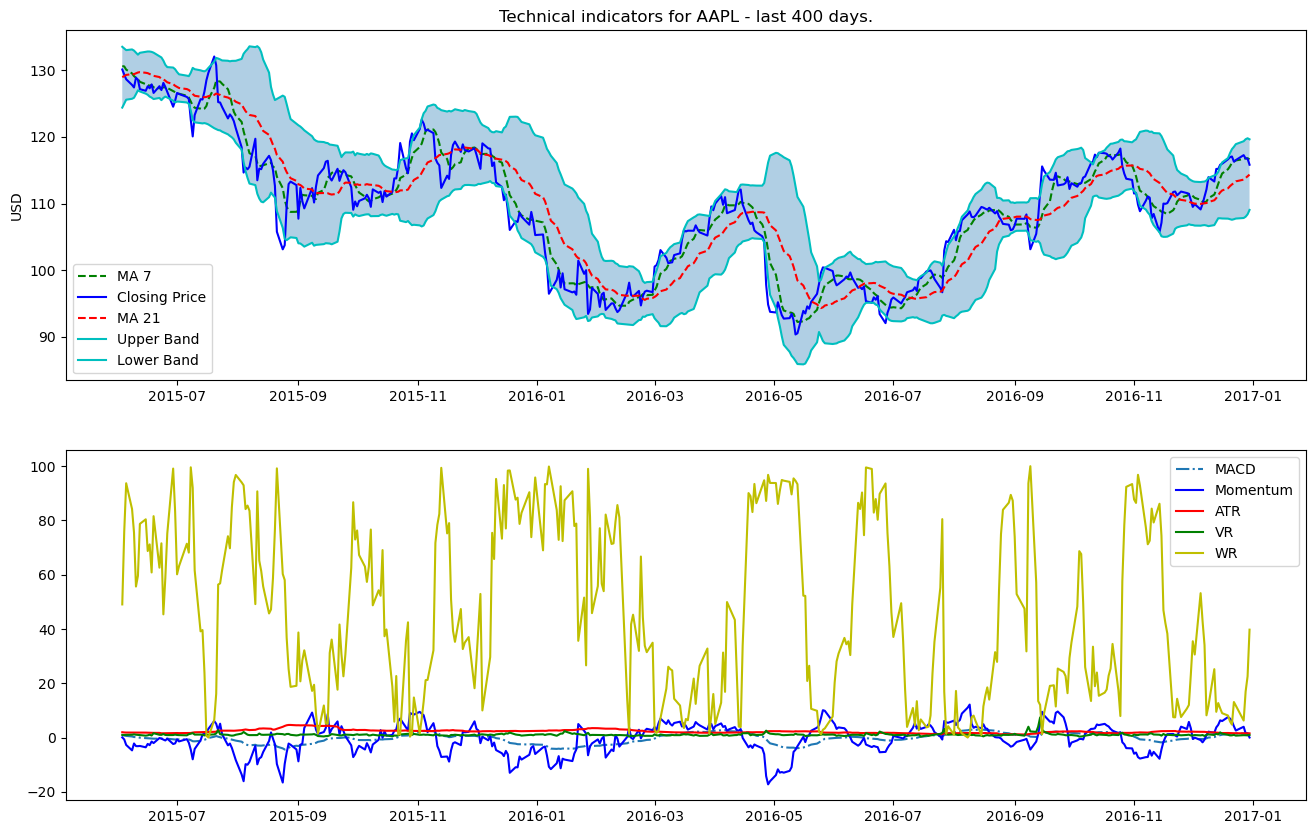

In [11]:
def plot_technical_indicators(dataset, last_days):
   plt.figure(figsize=(16, 10), dpi=100)
   shape_0 = dataset.shape[0]
   xmacd_ = shape_0-last_days
   
   dataset = dataset.iloc[-last_days:, :]
   x_ = range(3, dataset.shape[0])
   x_ =list(dataset.index)
   
   # Plot first subplot
   plt.subplot(2, 1, 1)
   plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
   plt.plot(dataset['Close'],label='Closing Price', color='b')
   plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
   plt.plot(dataset['upper_band'],label='Upper Band', color='c')
   plt.plot(dataset['lower_band'],label='Lower Band', color='c')
   plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
   plt.title('Technical indicators for AAPL - last {} days.'.format(last_days))
   plt.ylabel('USD')
   plt.legend()

   # Plot second subplot
   plt.subplot(2, 1, 2)
   plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
   #plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
   #plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
   plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')
   plt.plot(dataset['ATR'],label='ATR', color='r',linestyle='-')
   plt.plot(dataset['VR'],label='VR', color='g',linestyle='-')
   plt.plot(dataset['WR'],label='WR', color='y',linestyle='-')
   plt.legend()
   plt.show()

plot_technical_indicators(data_new, 400)

In [12]:
data_new.columns

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'ma7', 'ma21',
       '26ema', '12ema', 'MACD', '20sd', 'upper_band', 'lower_band', 'ema',
       'momentum', 'HLrange', 'HCrange', 'CLrange', 'TR', 'ATR', 'Vlchange',
       'VR', 'WR', 'MoneyFlow', 'Mfchange', 'MFI', 'OCR', 'Return'],
      dtype='object')

Now, we split the processed data into train/test dataset, with 90% to be the training samples.

In [13]:
# train test split

split_point = int(data_new.shape[0]*0.9)

X = data_new.loc[:,['High', 'Low', 'Open', 'Volume','ma7', 'ma21','26ema', '12ema', 'MACD','upper_band', 'lower_band', 'ema',
       'momentum','ATR','VR', 'WR','MFI', 'OCR']]
y = data_new.loc[:,['Return']]
#y = data_new.loc[:,['Close']]

X_train = X.iloc[:split_point,:]
X_test = X.iloc[split_point:,:]
y_train = y.iloc[:split_point,:]
y_test = y.iloc[split_point:,:]

We use MinMax scaling to make the data scaled into the range (0,1)

In [14]:
# scaling

sc_x = MinMaxScaler()
sc_y = MinMaxScaler()
X_train = sc_x.fit_transform(X_train)
X_test = sc_x.transform(X_test)

y_train = sc_y.fit_transform(y_train)
y_test = sc_y.transform(y_test)

#y_train = y_train.values
#y_test = y_test.values

Since our data is time series, we now create the rolled data with rolling_num = 15, which means we use the previous 15 days' data to predict the next one day's stock return.

In [15]:
def create_rolled_data(X,y,rolling_num=15):
    X_roll = []
    y_roll = []
    for i in range(rolling_num, X.shape[0]):
        X_roll.append(X[i-rolling_num:i,:])
        y_roll.append(y[i, 0])
    X_roll, y_roll = np.array(X_roll), np.array(y_roll)

    print(X_roll.shape)
    print(y_roll.shape)

    # Reshaping
    X_roll = np.reshape(X_roll, (X_roll.shape[0], X_roll.shape[1], X_roll.shape[2]))
    y_roll = np.reshape(y_roll,(y_roll.shape[0],1))
    
    return X_roll,y_roll

In [16]:
X_train_roll,y_train_roll = create_rolled_data(X_train,y_train,rolling_num=15)
X_test_roll,y_test_roll = create_rolled_data(X_test,y_test,rolling_num=15)

(3816, 15, 18)
(3816,)
(411, 15, 18)
(411,)


# Model building

Define the plotting function to plot the real stock return and the predicted ones.

In [17]:
def plot_prediction(real_stock_return,predicted_stock_return):
    plt.plot(real_stock_return, color = 'red', label = 'Real AAPL Stock Return')
    plt.plot(predicted_stock_return, color = 'blue', label = 'Predicted AAPL Stock Return')
    plt.title('AAPL Stock Return Prediction')
    plt.xlabel('samples')
    plt.ylabel('AAPL Stock Return')
    plt.legend()
    plt.show()

## 1. RNN model

Simple Rnn is a fully connected RNN where the output of the previous time step is fed to the next time step.

In [42]:
model1 = Sequential()
model1.add(SimpleRNN(units = 5, input_shape = (X_train_roll.shape[1], X_train_roll.shape[2]),activation='tanh'))
 
model1.add(Dense(units = 1))
model1.compile(optimizer = 'adam', loss = 'mse')

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5,restore_best_weights=True)
 
# model training
history = model1.fit(X_train_roll, y_train_roll, epochs = 100, batch_size = 100, 
                        validation_split=0.1,callbacks=[callback])

model1.summary()

Epoch 1/100
35/35 [==============================] - 1s 17ms/step - loss: 1.4830 - val_loss: 0.0994
Epoch 2/100
35/35 [==============================] - 0s 13ms/step - loss: 0.1057 - val_loss: 0.0520
Epoch 3/100
35/35 [==============================] - 0s 13ms/step - loss: 0.0366 - val_loss: 0.0519
Epoch 4/100
35/35 [==============================] - 0s 13ms/step - loss: 0.0274 - val_loss: 0.0458
Epoch 5/100
35/35 [==============================] - 0s 12ms/step - loss: 0.0218 - val_loss: 0.0380
Epoch 6/100
35/35 [==============================] - 0s 13ms/step - loss: 0.0173 - val_loss: 0.0309
Epoch 7/100
35/35 [==============================] - 0s 12ms/step - loss: 0.0137 - val_loss: 0.0251
Epoch 8/100
35/35 [==============================] - 0s 13ms/step - loss: 0.0108 - val_loss: 0.0205
Epoch 9/100
35/35 [==============================] - 0s 12ms/step - loss: 0.0085 - val_loss: 0.0168
Epoch 10/100
35/35 [==============================] - 0s 12ms/step - loss: 0.0067 - val_loss: 0.0141

35/35 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 0.0047
Epoch 83/100
35/35 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0047
Epoch 84/100
35/35 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 85/100
35/35 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 86/100
35/35 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 87/100
35/35 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 88/100
35/35 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 89/100
35/35 [==============================] - 0s 13ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 90/100
35/35 [==============================] - 0s 13ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 91/100
35/35 [==============================] - 0s 13ms/step - loss: 0.0011 - val_loss: 0.0045
Epo

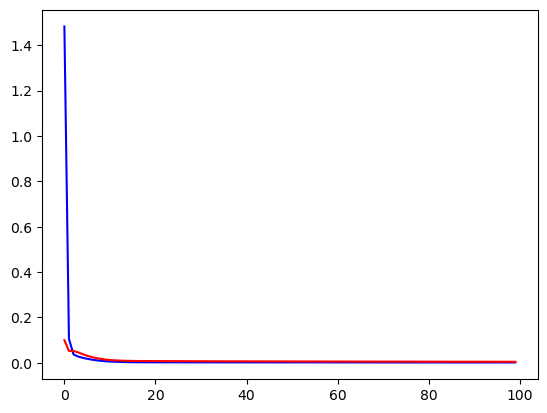

In [43]:
plt.plot(history.history['loss'],c='blue')    # training loss
plt.plot(history.history['val_loss'],c='red') # test loss
plt.show()

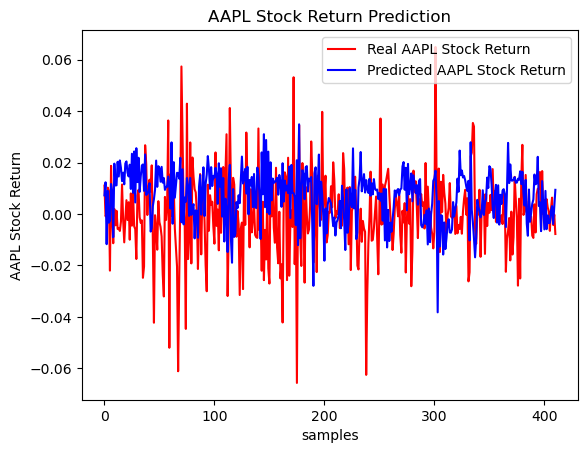

In [44]:
predicted_stock_return = model1.predict(X_test_roll)
predicted_stock_return = sc_y.inverse_transform(predicted_stock_return)

#real_stock_return = sc.inverse_transform(y_test_roll)
real_stock_return = sc_y.inverse_transform(y_test_roll)

plot_prediction(real_stock_return,predicted_stock_return)

In [45]:
mse = MeanSquaredError()
mse(real_stock_return, predicted_stock_return).numpy()

0.00041141253

From the graph, we can find that RNN can reflect the volatility of the returns while fail to predict the extreme values.

We will try some more complex models.

## LSTM

LSTM is a more advanced RNN model. The attempts to set the appropariate hyperparameters need more effort than the simple RNN model. Here are the findings: \
    1. softsign activation function performs generally better than relu, since it is nonlinear and is a 'narrowed' version of tanh, which fit the return data better. \
    2. The batch size should be smaller than the simple RNN model. \
    3. Even the return data is already within range (0,1), after the comparison, scaled y values give better training and test performance.

Epoch 1/100
69/69 [==============================] - 7s 66ms/step - loss: 0.4305 - mse: 0.4305 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 2/100
69/69 [==============================] - 4s 62ms/step - loss: 0.0136 - mse: 0.0136 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 3/100
69/69 [==============================] - 4s 61ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0053 - val_mse: 0.0053
Epoch 4/100
69/69 [==============================] - 4s 62ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 5/100
69/69 [==============================] - 4s 62ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 6/100
69/69 [==============================] - 4s 61ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 7/100
69/69 [==============================] - 4s 60ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 8/100
69/69 [==============================] - 4s 60ms/step - loss: 0.

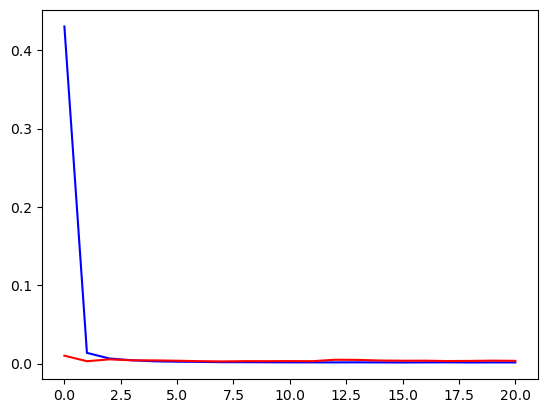

In [48]:
model2 = Sequential()
model2.add(LSTM(units=128, return_sequences=True, input_shape=[X_train_roll.shape[1], X_train_roll.shape[2]],activation='softsign'))
model2.add(Dropout(0.3))
model2.add(BatchNormalization())
 

model2.add(LSTM(units=128,return_sequences=False,activation='softsign'))
model2.add(BatchNormalization())

model2.add(Dense(32,activation='sigmoid'))
model2.add(Dense(1,activation='linear'))


model2.compile(optimizer='adam',
              loss='mean_squared_error',
             metrics=['mse'])
                      
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5,restore_best_weights=True)
history = model2.fit(X_train_roll, y_train_roll, epochs = 100, batch_size = 50,
          shuffle = False, validation_split=0.1,callbacks=[callback])

plt.plot(history.history['loss'],c='blue')    # training loss
plt.plot(history.history['val_loss'],c='red') # test loss
plt.show()

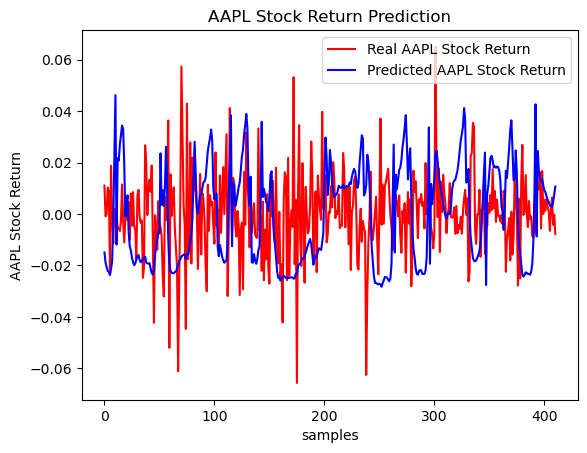

In [49]:
predicted_stock_return = model2.predict(X_test_roll)
predicted_stock_return = sc_y.inverse_transform(predicted_stock_return)

real_stock_return = sc_y.inverse_transform(y_test_roll)

plot_prediction(real_stock_return,predicted_stock_return)

In [27]:
mse(real_stock_return, predicted_stock_return).numpy()

0.0003522173

From the graph, we can see that LSTM predicts the volatility less while more on the general trend, while there is always a lag. Also the MSE value is less than the RNN model.

In the hyperperameter tuning process, 2 LSTM layers are better than 1 in avoiding underfitting problem, while it is necessary to add a dropout layer after the first LSTM layer.

## CNN+LSTM

We continue on trying more complex models. This model first converts a window of stock data into a 2D image data, and then performs feature extraction through CNN. When extracting stock features from the perspective of the image, each row of the image contains a temporal relationship, and each column contains some spatial relationships.

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 15, 18, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 15, 18, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 18, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 18, 32)        0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 15, 576)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 15, 128)           360960    
_________________________________________________________________
batch_normalization_4 (Batch (None, 15, 128)          

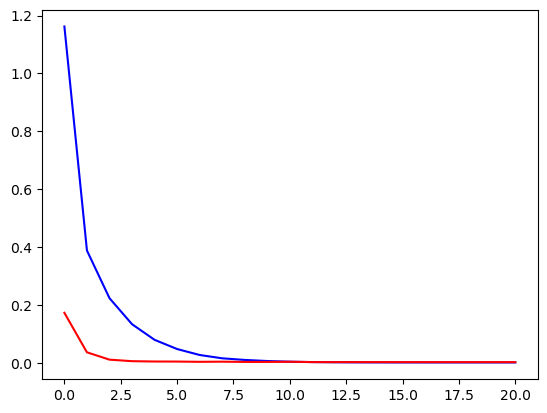

In [30]:
window_size = X_train_roll.shape[1]
fea_num = X_train_roll.shape[2]


model3 = keras.models.Sequential([
    keras.layers.Input((window_size, fea_num)),
    keras.layers.Reshape((window_size, fea_num, 1)),
    keras.layers.Conv2D(filters=32,
                           kernel_size=3,
                           strides=1,
                           padding="same",
                           activation="tanh"),
    keras.layers.MaxPooling2D(pool_size=2, strides=1, padding="same"),
    Dropout(0.5),
    Reshape((window_size, -1)),
    LSTM(128, return_sequences=True,activation='softsign'),
    BatchNormalization(),
    LSTM(64, return_sequences=False,activation='softsign'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation="linear"),
    Dense(1)
])
 
 
model3.compile(loss='mse', optimizer='adam', metrics=['mse'])
model3.summary()
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3,restore_best_weights=True)
history = model3.fit(X_train_roll, y_train_roll, epochs = 100, batch_size = 100,
          shuffle = True, validation_split=0.1,callbacks=[callback])

plt.plot(history.history['loss'],c='blue')    
plt.plot(history.history['val_loss'],c='red') 
plt.show()



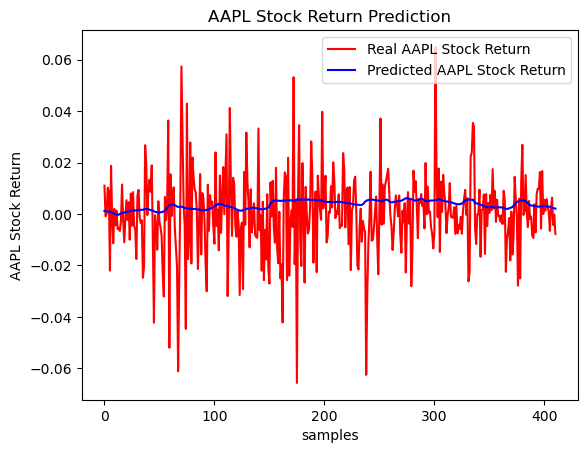

In [32]:
predicted_stock_return = model3.predict(X_test_roll)
predicted_stock_return = sc_y.inverse_transform(predicted_stock_return)

real_stock_return = sc_y.inverse_transform(y_test_roll)

plot_prediction(real_stock_return,predicted_stock_return)

In [34]:
mse(real_stock_return,predicted_stock_return).numpy()

0.00025904158

Even though the MSE value decrease, he prediction is almost a straight line and no improvement can be obtained by multiple parameter adjustments as in the LSTM model.

## Tranformers

In [70]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    
    # Normalization and Attention
    # "EMBEDDING LAYER"
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    
    # "ATTENTION LAYER"
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs
    
    # FEED FORWARD Part - you can stick anything here or just delete the whole section - it will still work. 
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation = "relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [71]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    
    for _ in range(num_transformer_blocks):  # This is what stacks our transformer blocks
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="elu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x) #this is a pass-through
    return keras.Model(inputs, outputs)

The main part of our model is now complete.
We can stack multiple of those transformer_encoder blocks and we can also proceed to add the final Multi-Layer Perceptron/ DNN head. \
Apart from a stack of Dense layers, we need to reduce the output tensor of the TransformerEncoder part of our model down to a vector of features for each data point in the current batch. A pooling layer like GlobalAveragePooling1D layer will do this.

In [72]:
callbacks = [keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]

In [73]:
input_shape = X_train_roll.shape[1:]
model4 = build_model(
    input_shape,
    head_size=46, # Embedding size for attention
    num_heads=60, # Number of attention heads
    ff_dim=55, # Hidden layer size in feed forward network inside transformer
    num_transformer_blocks=6,
    mlp_units=[128],
    mlp_dropout=0.2,
    dropout=0.2,
)

model4.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["mse"],
)
model4.summary()


history = model4.fit(
    X_train_roll,
    y_train_roll,
    validation_split=0.2,
    epochs=100,
    batch_size=50,
    callbacks=callbacks,
)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 15, 18)]     0                                            
__________________________________________________________________________________________________
layer_normalization (LayerNorma (None, 15, 18)       36          input_3[0][0]                    
__________________________________________________________________________________________________
multi_head_attention (MultiHead (None, 15, 18)       207018      layer_normalization[0][0]        
                                                                 layer_normalization[0][0]        
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 15, 18)       0           multi_head_attention[0][0]   

62/62 [==============================] - 9s 46ms/step - loss: 0.1319 - mse: 0.1319 - val_loss: 0.0165 - val_mse: 0.0165
Epoch 2/100
62/62 [==============================] - 2s 35ms/step - loss: 0.0358 - mse: 0.0358 - val_loss: 0.0153 - val_mse: 0.0153
Epoch 3/100
62/62 [==============================] - 2s 36ms/step - loss: 0.0275 - mse: 0.0275 - val_loss: 0.0380 - val_mse: 0.0380
Epoch 4/100
62/62 [==============================] - 2s 36ms/step - loss: 0.0199 - mse: 0.0199 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 5/100
62/62 [==============================] - 2s 35ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 6/100
62/62 [==============================] - 2s 36ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 7/100
62/62 [==============================] - 2s 35ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 8/100
62/62 [==============================] - 2s 36ms/step - loss: 0.0059 - mse: 

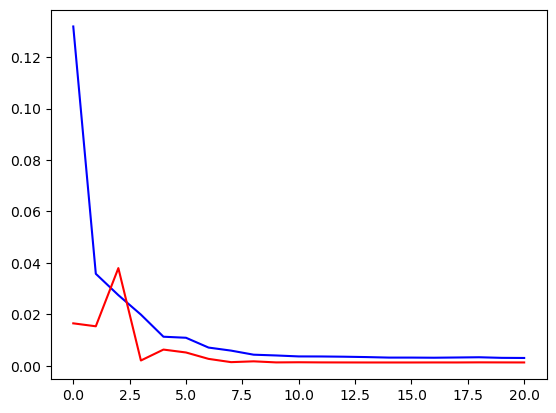

In [74]:
plt.plot(history.history['loss'],c='blue')    # training loss
plt.plot(history.history['val_loss'],c='red') # test loss
plt.show()

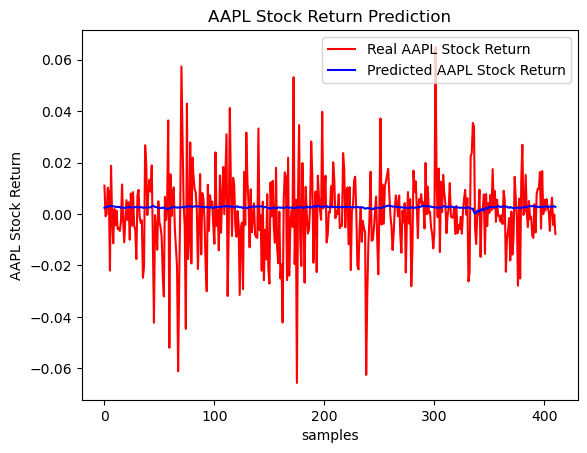

In [75]:
predicted_stock_return = model4.predict(X_test_roll)
predicted_stock_return = sc_y.inverse_transform(predicted_stock_return)

real_stock_return = sc_y.inverse_transform(y_test_roll)

plot_prediction(real_stock_return,predicted_stock_return)

In [76]:
mse = MeanSquaredError()
mse(real_stock_return, predicted_stock_return).numpy()

0.0002543745

What really counts is predicting returns. However if we use stock['Return'] instead of stock['Close'] vanishing gradients appear.

# Conclusion

We expect that the advanced models could give better performance in time series prediction, while the CNN+LSTM model and transformer model fail to even simulate the effect of fluctuation. \
I have tried the RNN model directly on predicting the stock['Close'], the result is much better than predicting stock['Return']. We need to further consider the characteristics of the return data itself, which is more like a "while noise" series than a series with short-term and long-term trends. Complex models may not be applicable in predicting this type of data.

# Save the LSTM model

I saved the LSTM model in this notebook.

In [64]:
import os
from tensorflow.keras.models import load_model

modelName = "final_model"
model_path = os.path.join(".", modelName)

def saveModel(model, model_path): 
    try:
        os.makedirs(model_path)
    except OSError:
        print("Directory {dir:s} already exists, files will be over-written.".format(dir=model_path))
        
    # Save JSON config to disk
    json_config = model.to_json()
    with open(os.path.join(model_path, 'config.json'), 'w') as json_file:
        json_file.write(json_config)
    # Save weights to disk
    model.save_weights(os.path.join(model_path, 'weights.h5'))
    
    print("Model saved in directory {dir:s}; create an archive of this directory and submit with your assignment.".format(dir=model_path))

    
    

In [65]:
my_model = model2
saveModel(my_model, model_path)

Model saved in directory .\final_model; create an archive of this directory and submit with your assignment.


In [77]:
print("Done")

Done
